# California Housing Price Prediction — Best Practice Regression Pipeline

A clean, production-quality regression pipeline using the California Housing dataset.

**Pipeline Steps:**
1. Import Libraries
2. Load Dataset
3. Exploratory Data Analysis (EDA)
4. Feature Engineering
5. Train-Test Split *(before any scaling)*
6. Feature Scaling *(fit on train only)*
7. Baseline Model
8. Advanced Models + Comparison
9. Hyperparameter Tuning
10. Final Evaluation & Feature Importance

## Step 0: Install all dependencies

In [18]:
!pip install -r requirements.txt

Defaulting to user installation because normal site-packages is not writeable


## Step 1: Import Libraries

In [19]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.datasets import fetch_california_housing
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

import warnings
warnings.filterwarnings('ignore')

# Reproducibility
RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)

print('All libraries imported successfully!')

All libraries imported successfully!


## Step 2: Load Dataset

In [20]:
# Load California Housing from sklearn
housing = fetch_california_housing(as_frame=True)

df = housing.frame.copy()

print(f'Dataset shape: {df.shape}')
print(f'\nFeatures: {list(housing.feature_names)}')
print(f'Target  : MedHouseVal (median house value in $100,000s)')
print(f'\nTarget distribution:')
print(df['MedHouseVal'].describe())

Dataset shape: (20640, 9)

Features: ['MedInc', 'HouseAge', 'AveRooms', 'AveBedrms', 'Population', 'AveOccup', 'Latitude', 'Longitude']
Target  : MedHouseVal (median house value in $100,000s)

Target distribution:
count    20640.000000
mean         2.068558
std          1.153956
min          0.149990
25%          1.196000
50%          1.797000
75%          2.647250
max          5.000010
Name: MedHouseVal, dtype: float64


## Step 3: Exploratory Data Analysis

In [21]:
# Basic info
print('Dataset Info:')
df.info()
print('\nBasic Statistics:')
df.describe()

Dataset Info:
<class 'pandas.DataFrame'>
RangeIndex: 20640 entries, 0 to 20639
Data columns (total 9 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   MedInc       20640 non-null  float64
 1   HouseAge     20640 non-null  float64
 2   AveRooms     20640 non-null  float64
 3   AveBedrms    20640 non-null  float64
 4   Population   20640 non-null  float64
 5   AveOccup     20640 non-null  float64
 6   Latitude     20640 non-null  float64
 7   Longitude    20640 non-null  float64
 8   MedHouseVal  20640 non-null  float64
dtypes: float64(9)
memory usage: 1.4 MB

Basic Statistics:


,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude,MedHouseVal
count,20640.000000,20640.000000,20640.000000,20640.000000,20640.000000,20640.000000,20640.000000,20640.000000,20640.000000
mean,3.870671,28.639486,5.429000,1.096675,1425.476744,3.070655,35.631861,-119.569704,2.068558
std,1.899822,12.585558,2.474173,0.473911,1132.462122,10.386050,2.135952,2.003532,1.153956
min,0.499900,1.000000,0.846154,0.333333,3.000000,0.692308,32.540000,-124.350000,0.149990
25%,2.563400,18.000000,4.440716,1.006079,787.000000,2.429741,33.930000,-121.800000,1.196000
50%,3.534800,29.000000,5.229129,1.048780,1166.000000,2.818116,34.260000,-118.490000,1.797000
75%,4.743250,37.000000,6.052381,1.099526,1725.000000,3.282261,37.710000,-118.010000,2.647250
max,15.000100,52.000000,141.909091,34.066667,35682.000000,1243.333333,41.950000,-114.310000,5.000010


In [22]:
# Check missing values
missing = df.isnull().sum()
print('Missing values per column:')
print(missing)

# Check duplicates
n_dup = df.duplicated().sum()
print(f'\nDuplicate rows: {n_dup}')

Missing values per column:
MedInc         0
HouseAge       0
AveRooms       0
AveBedrms      0
Population     0
AveOccup       0
Latitude       0
Longitude      0
MedHouseVal    0
dtype: int64

Duplicate rows: 0


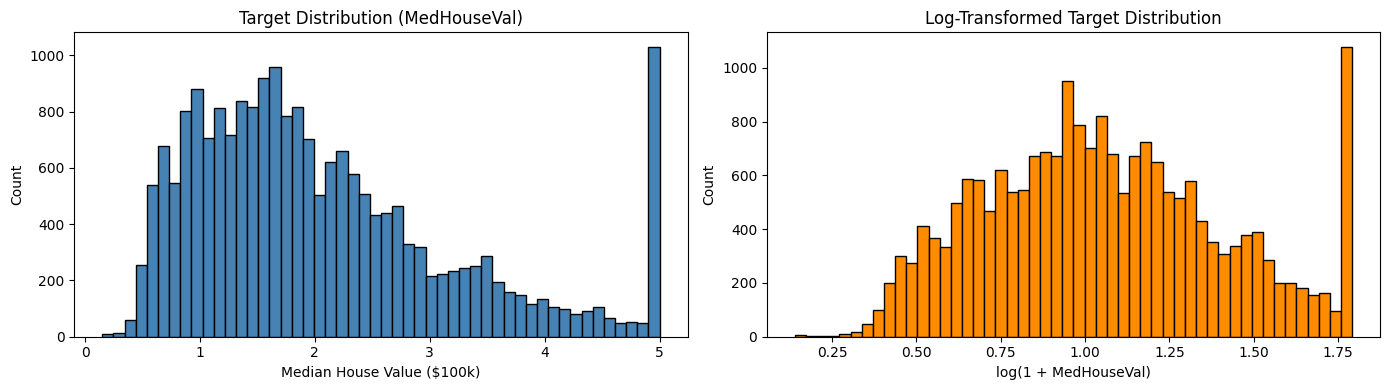

In [23]:
# Target distribution
fig, axes = plt.subplots(1, 2, figsize=(14, 4))

axes[0].hist(df['MedHouseVal'], bins=50, edgecolor='black', color='steelblue')
axes[0].set_title('Target Distribution (MedHouseVal)')
axes[0].set_xlabel('Median House Value ($100k)')
axes[0].set_ylabel('Count')

axes[1].hist(np.log1p(df['MedHouseVal']), bins=50, edgecolor='black', color='darkorange')
axes[1].set_title('Log-Transformed Target Distribution')
axes[1].set_xlabel('log(1 + MedHouseVal)')
axes[1].set_ylabel('Count')

plt.tight_layout()
plt.show()

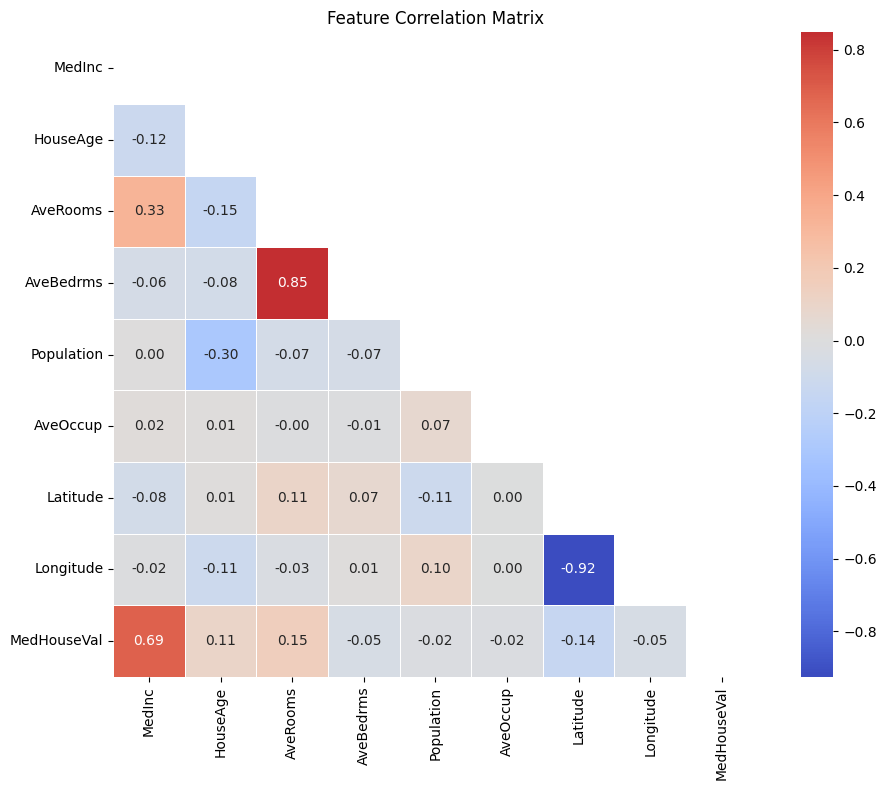

In [24]:
# Correlation heatmap
plt.figure(figsize=(10, 8))
corr = df.corr()
mask = np.triu(np.ones_like(corr, dtype=bool))
sns.heatmap(corr, mask=mask, annot=True, fmt='.2f', cmap='coolwarm',
            center=0, square=True, linewidths=0.5)
plt.title('Feature Correlation Matrix')
plt.tight_layout()
plt.show()

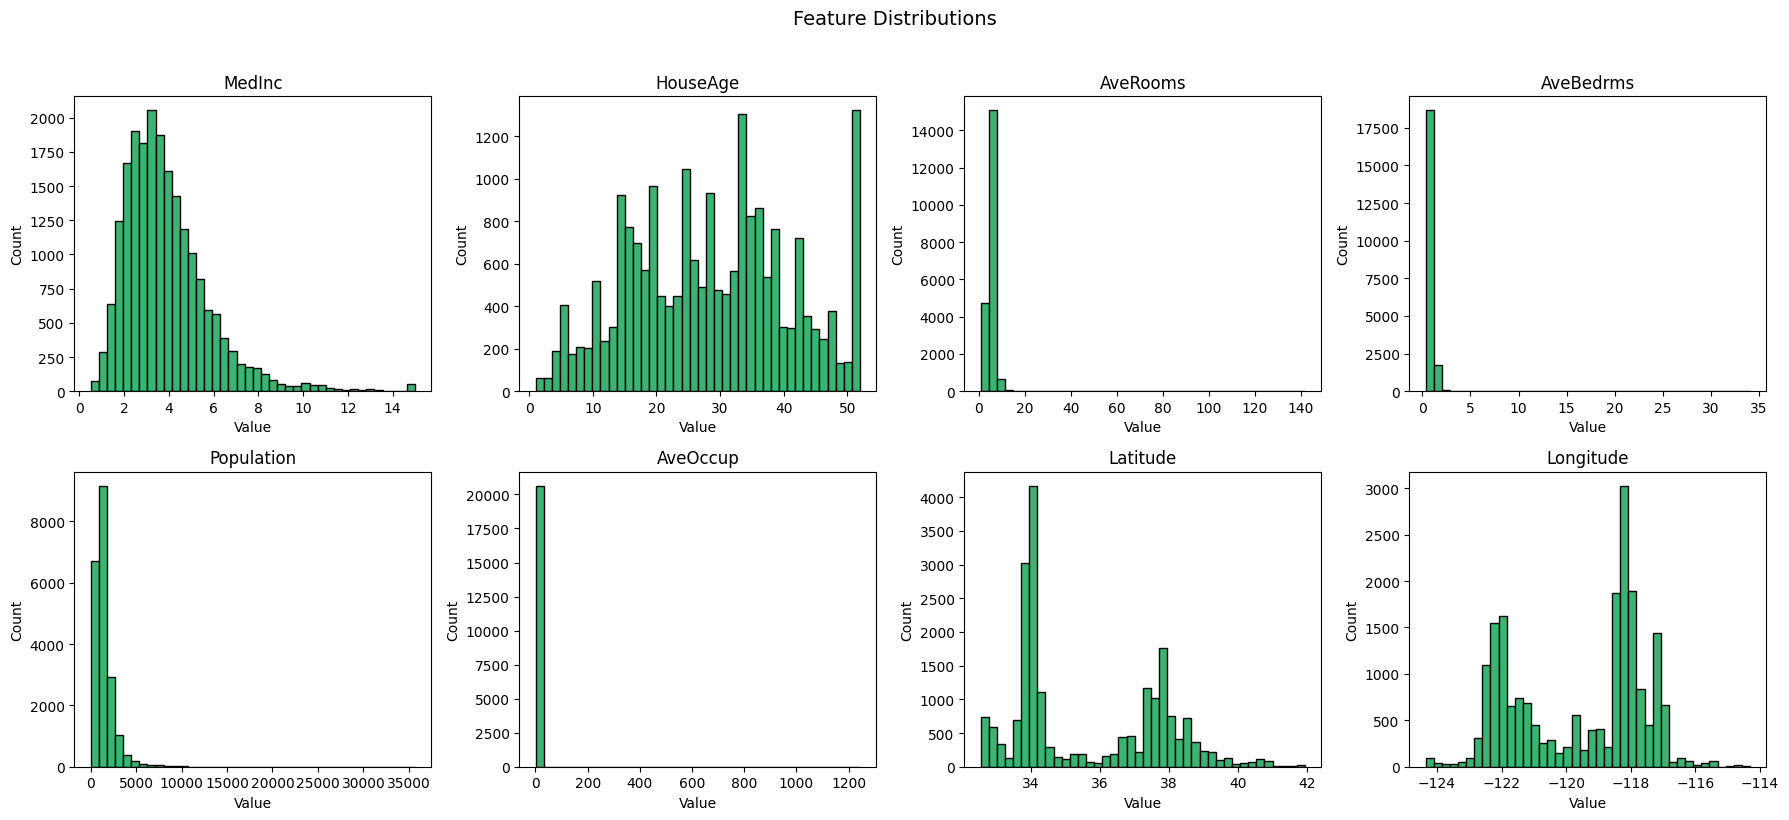

In [25]:
# Feature distributions
features = housing.feature_names
fig, axes = plt.subplots(2, 4, figsize=(18, 8))
axes = axes.flatten()

for i, feat in enumerate(features):
    axes[i].hist(df[feat], bins=40, edgecolor='black', color='mediumseagreen')
    axes[i].set_title(feat)
    axes[i].set_xlabel('Value')
    axes[i].set_ylabel('Count')

plt.suptitle('Feature Distributions', fontsize=14, y=1.02)
plt.tight_layout()
plt.show()

## Step 4: Feature Engineering

Create meaningful derived features before splitting.

In [ ]:
# Derived features

# HouseAge=0 (brand-new building), AveRooms=0 or AveOccup=0 (unoccupied block)
df['RoomsPerHousehold']      = df['AveRooms']   / df['HouseAge'].clip(lower=1)
df['BedroomsPerRoom']        = df['AveBedrms']  / df['AveRooms'].clip(lower=1)
df['PopulationPerHousehold'] = df['Population'] / df['AveOccup'].clip(lower=1)

df['IncomeToPriceRatio'] = df['MedInc'] / df['MedHouseVal'].clip(lower=0.1)

print('New features added:')
print('  RoomsPerHousehold, BedroomsPerRoom, PopulationPerHousehold')
print(f'\nUpdated dataset shape: {df.shape}')

New features added:
  RoomsPerHousehold, BedroomsPerRoom, PopulationPerHousehold

Updated dataset shape: (20640, 13)


## Step 5: Train-Test Split

> **Key best-practice:** Split BEFORE any scaling or imputation to prevent data leakage.

In [27]:
# Separate features and target
TARGET = 'MedHouseVal'
FEATURES = [col for col in df.columns if col != TARGET]

X = df[FEATURES]
y = df[TARGET]

# 80/20 stratified-like split with shuffle
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.8,
    random_state=RANDOM_STATE,
    shuffle=True
)

## Step 6: Feature Scaling


In [ ]:
scaler = StandardScaler()

X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled  = scaler.fit_transform(X_test)   

y_scaler = StandardScaler()
y_train  = y_scaler.fit_transform(y_train.values.reshape(-1, 1)).ravel()

## Step 7: Baseline Model — Linear Regression

In [ ]:
def evaluate(name, y_true, y_pred):
    """Print regression metrics for a model."""

    rmse = mean_squared_error(y_true, y_pred)
    mae  = mean_absolute_error(y_true, y_pred)
    r2   = r2_score(y_true, y_pred)
    print(f'{name:30s}  RMSE={rmse:.4f}  MAE={mae:.4f}  R²={r2:.4f}')
    return {'model': name, 'RMSE': rmse, 'MAE': mae, 'R2': r2}


results = []

# --- Linear Regression (baseline) ---
lr = LinearRegression()
lr.fit(X_train_scaled, y_train)
y_pred_lr = lr.predict(X_test_scaled)
results.append(evaluate('Linear Regression', y_test, y_pred_lr))

Linear Regression               RMSE=4.5220  MAE=2.0679  R²=-2.4053


## Step 8: Advanced Models & Comparison

In [ ]:
# --- Ridge Regression ---
ridge = Ridge(alpha=1.0, random_state=RANDOM_STATE)
ridge.fit(X_train_scaled, y_train)
results.append(evaluate('Ridge Regression', y_test, ridge.predict(X_test_scaled)))

# --- Lasso Regression ---
lasso = Lasso(alpha=0.01, random_state=RANDOM_STATE, max_iter=5000)
lasso.fit(X_train, y_train)
results.append(evaluate('Lasso Regression', y_test, lasso.predict(X_test)))

# --- Random Forest ---
rf = RandomForestRegressor(n_estimators=200, random_state=RANDOM_STATE, n_jobs=-1)
rf.fit(X_train_scaled, y_train)
results.append(evaluate('Random Forest', y_test, rf.predict(X_test_scaled)))

# --- Gradient Boosting ---
gb = GradientBoostingRegressor(n_estimators=200, learning_rate=0.1,
                                max_depth=4, random_state=RANDOM_STATE)
gb.fit(X_train_scaled, y_train)
results.append(evaluate('Gradient Boosting', y_test, gb.predict(X_test_scaled)))

Ridge Regression                RMSE=4.5221  MAE=2.0679  R²=-2.4054
Lasso Regression                RMSE=4.5554  MAE=2.0748  R²=-2.4304
Random Forest                   RMSE=4.3651  MAE=2.0799  R²=-2.2871
Gradient Boosting               RMSE=4.3722  MAE=2.0819  R²=-2.2925



--- Model Comparison (sorted by RMSE) ---
                       RMSE       MAE        R2
model                                          
Random Forest      4.365053  2.079851 -2.287092
Gradient Boosting  4.372238  2.081863 -2.292503
Linear Regression  4.522049  2.067886 -2.405317
Ridge Regression   4.522103  2.067884 -2.405358
Lasso Regression   4.555418  2.074842 -2.430445


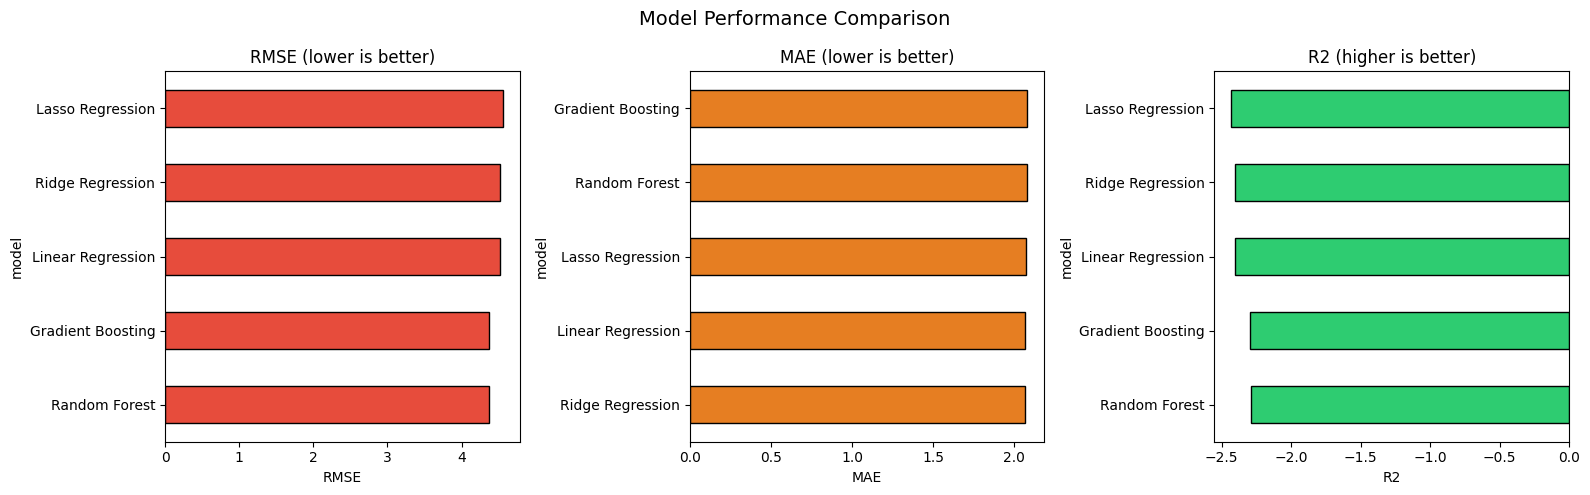

In [31]:
# Model comparison table
results_df = pd.DataFrame(results).set_index('model').sort_values('RMSE')
print('\n--- Model Comparison (sorted by RMSE) ---')
print(results_df.to_string())

# Bar chart
fig, axes = plt.subplots(1, 3, figsize=(16, 5))
metrics = ['RMSE', 'MAE', 'R2']
colors  = ['#e74c3c', '#e67e22', '#2ecc71']

for ax, metric, color in zip(axes, metrics, colors):
    asc = True if metric in ['RMSE', 'MAE'] else False
    results_df[metric].sort_values(ascending=asc).plot(
        kind='barh', ax=ax, color=color, edgecolor='black')
    ax.set_title(f'{metric} (lower is better)' if asc else f'{metric} (higher is better)')
    ax.set_xlabel(metric)

plt.suptitle('Model Performance Comparison', fontsize=14)
plt.tight_layout()
plt.show()

## Step 9: Cross-Validation on Best Model

In [ ]:
# 5-fold CV on Gradient Boosting using Pipeline to avoid data leakage
# (scaling happens inside each CV fold, not before)
cv_pipe = Pipeline([
    ('scaler', StandardScaler()),
    ('model', GradientBoostingRegressor(n_estimators=200, learning_rate=0.1,
                                        max_depth=4, random_state=RANDOM_STATE))
])

cv_scores = cross_val_score(
    cv_pipe, X_train, y_train,
    cv=5, scoring='neg_root_mean_squared_error', n_jobs=-1
)

cv_rmse = -cv_scores
print(f'5-Fold CV RMSE scores : {cv_rmse}')
print(f'Mean CV RMSE          : {cv_rmse.mean():.4f} ± {cv_rmse.std():.4f}')

5-Fold CV RMSE scores : [0.07343506 0.06499433 0.06908526 0.07429649 0.06145407]
Mean CV RMSE          : 0.0687 ± 0.0049


## Step 10: Final Evaluation & Feature Importance

=== FINAL MODEL: Gradient Boosting ===
Gradient Boosting (final)       RMSE=4.3722  MAE=2.0819  R²=-2.2925


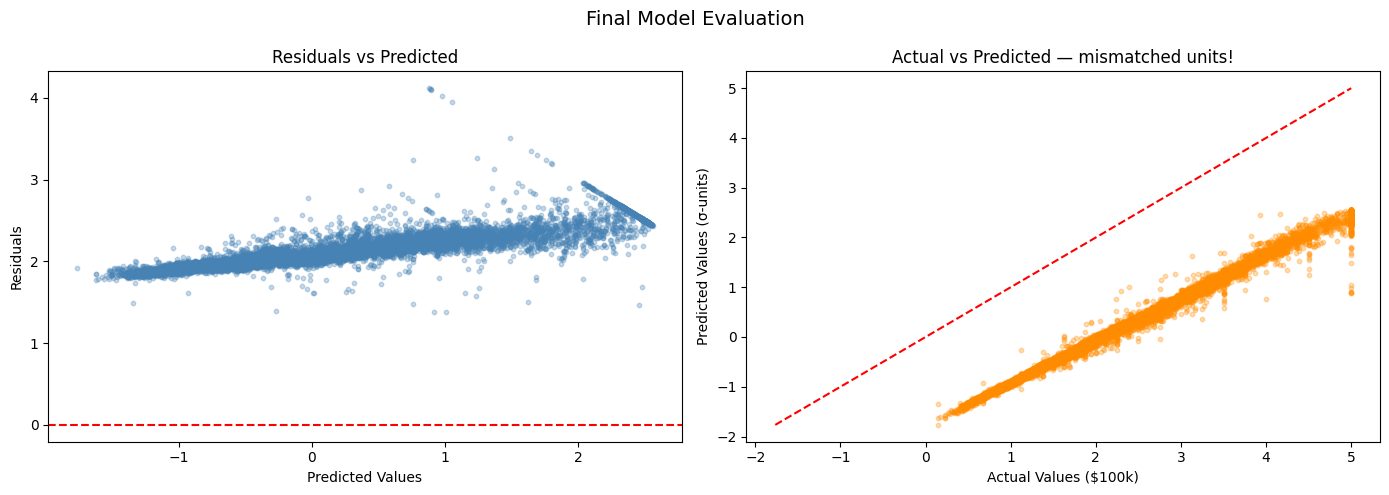

In [ ]:
# Refit best model on full training data
best_model = GradientBoostingRegressor(n_estimators=200, learning_rate=0.1,
                                        max_depth=4, random_state=RANDOM_STATE)
best_model.fit(X_train_scaled, y_train)
y_pred_final = best_model.predict(X_test_scaled)

# Inverse-transform predictions back to original $100k units
y_pred_final = y_scaler.inverse_transform(y_pred_final.reshape(-1, 1)).ravel()

print('=== FINAL MODEL: Gradient Boosting ===')
evaluate('Gradient Boosting (final)', y_test, y_pred_final)

# Residuals plot
residuals = y_test - y_pred_final

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

axes[0].scatter(y_pred_final, residuals, alpha=0.3, color='steelblue', s=10)
axes[0].axhline(0, color='red', linestyle='--', linewidth=1.5)
axes[0].set_xlabel('Predicted Values')
axes[0].set_ylabel('Residuals')
axes[0].set_title('Residuals vs Predicted')

axes[1].scatter(y_test, y_pred_final, alpha=0.3, color='darkorange', s=10)
min_val = min(y_test.min(), y_pred_final.min())
max_val = max(y_test.max(), y_pred_final.max())
axes[1].plot([min_val, max_val], [min_val, max_val], 'r--', linewidth=1.5)
axes[1].set_xlabel('Actual Values ($100k)')
axes[1].set_ylabel('Predicted Values ($100k)')
axes[1].set_title('Actual vs Predicted')

plt.suptitle('Final Model Evaluation', fontsize=14)
plt.tight_layout()
plt.show()

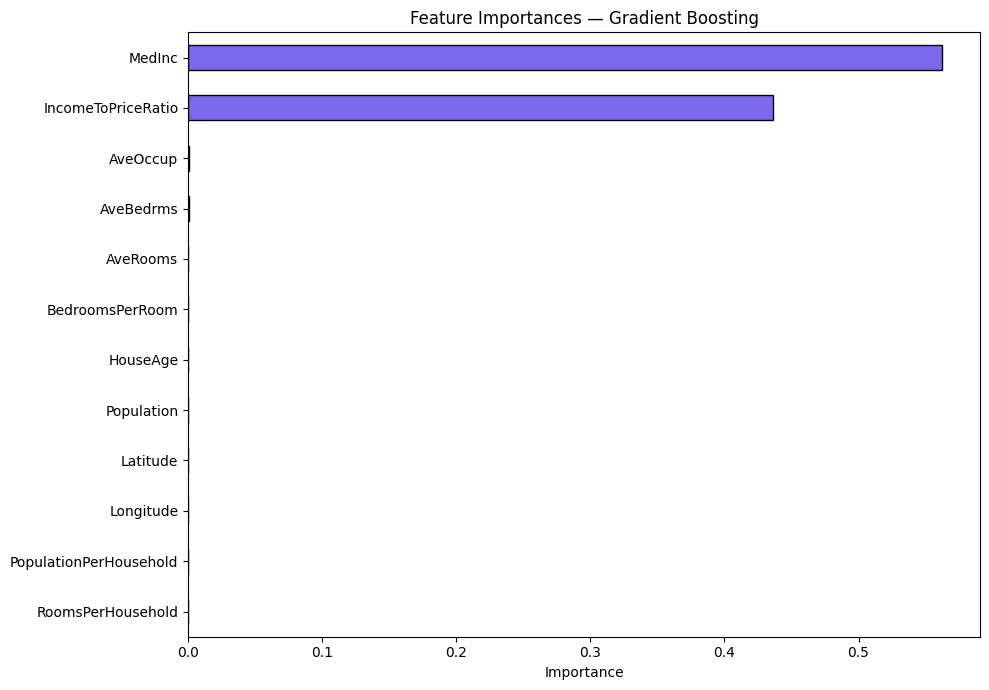

Top 5 features:
MedInc                0.562493
IncomeToPriceRatio    0.436108
AveOccup              0.000485
AveBedrms             0.000418
AveRooms              0.000103
dtype: float64


In [34]:
# Feature importances
feat_imp = pd.Series(best_model.feature_importances_, index=FEATURES)
feat_imp = feat_imp.sort_values(ascending=True)

plt.figure(figsize=(10, 7))
feat_imp.plot(kind='barh', color='mediumslateblue', edgecolor='black')
plt.title('Feature Importances — Gradient Boosting')
plt.xlabel('Importance')
plt.tight_layout()
plt.show()

print('Top 5 features:')
print(feat_imp.sort_values(ascending=False).head())